In [1]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [2]:
sample_list = ['CRC-P19-T','CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T','LC05-M_DU3','LC05-T_FD3','dcis1','dcis2','slide_DNA','slide_RNA']

In [3]:
plat_color = ['#FF8A7D','#FC8E82','#FA9185','#E47479','#E57579','#E57579'] + ['#F8C170','#FBB479']+ ['#71BE4B'] + ['#00A1DF']
plat = ['stereo-seq']*6 + ['visium'] *2 + ['slide']*2

# fig1B

In [6]:
sample = 'CRC-P59-T_1'
cell_counts = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/snv_cells/{sample}.cells.csv')
sample = 'dcis1'
cell_counts1 = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/snv_cells/{sample}.cells.csv')
sample = 'slide_RNA'
cell_counts2 = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/snv_cells/{sample}.cells.csv')
sample = 'slide_DNA'
cell_counts3 = pd.read_csv(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/snv_cells/{sample}.cells.csv')

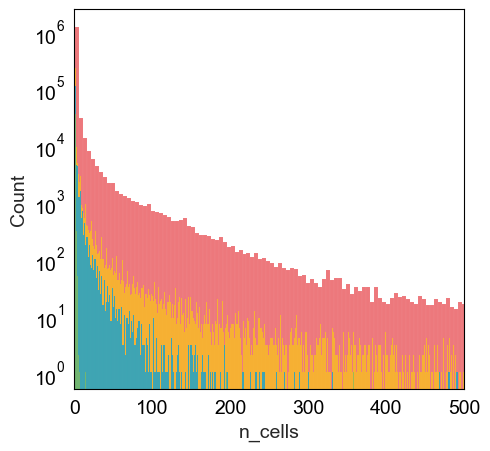

In [7]:
fig,ax = plt.subplots(figsize = (5,5))
palette= {'Slide-seq': "#00A1DF", 'Stereo-seq': '#E84B50', 'Visium': '#FAC319'}
hist = sns.histplot(cell_counts['n_cells'], bins=1000, kde=False,ax =ax,color = '#E84B50',edgecolor=None,rasterized =True)

hist = sns.histplot(cell_counts1['n_cells'], bins=1000, kde=False,ax =ax,color = '#FAC319',edgecolor=None,rasterized =True)

hist = sns.histplot(cell_counts2['n_cells'], bins=1000, kde=False,ax =ax,color = '#00A1DF',edgecolor=None,rasterized =True)

hist = sns.histplot(cell_counts3['n_cells'], bins=1000, kde=False,ax =ax,color = '#83BC5B',edgecolor=None,rasterized =True)
ax.set_xlim(0,500)
ax.set_yscale('log')
ax.grid(False)

In [8]:
data = pd.read_csv('./readstat/stat.summary.csv',sep = '\t',header=None,names=['platform','sample','reads'])
count_dict = {}
for sample in sample_list:
    snv = sc.read_h5ad(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/{sample}.snv.h5ad')
    count_dict[sample] = snv.shape[1]
data['snvreads'] = data['sample'].map(count_dict)
unique_platforms = data['platform'].unique()
platform_to_color = {'Slide-RNA': "#00A1DF", 'Stereo-seq': '#E84B50', 'Visium': '#FAC319','Slide-DNA':'#83BC5B'}

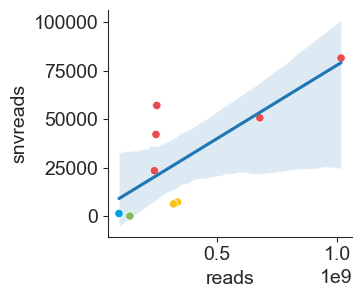

In [9]:
sns.set_style('ticks', {'axes.grid' : False})
g = sns.lmplot(data=data, x='reads', y='snvreads',height=3.2,aspect=1.2,legend=False,scatter = False)
for ax in g.axes.flatten():
    sns.scatterplot(data = data,x='reads', y='snvreads',hue = 'platform',ax = ax,palette=platform_to_color,legend=False)

# Figure 1C

In [10]:
stat_df = []
snv_set = {}
for sample in sample_list:
    if sample !='slide_DNA':
        snv = sc.read_h5ad(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/{sample}.snv.h5ad')
        stat = pd.DataFrame({sample:snv.var['Func_L0'].value_counts().loc[['UTR','Exonic','Intronic', 'Intergenic']].values})
        stat_df.append(stat)
        if sample.startswith('CRC'):
            snv_set[sample] = set(snv.var_names.tolist())
        if sample.startswith('LC'):
            snv_set[sample] = set(('chr'+ snv.var_names).tolist())
component_stat_df = pd.concat(stat_df,axis = 1).T
component_stat_df.columns = ['UTR','Exonic','Intronic', 'Intergenic']
component_stat_df = component_stat_df[::-1]
total = component_stat_df.sum(axis=1)
proportions = component_stat_df.divide(total, axis=0)

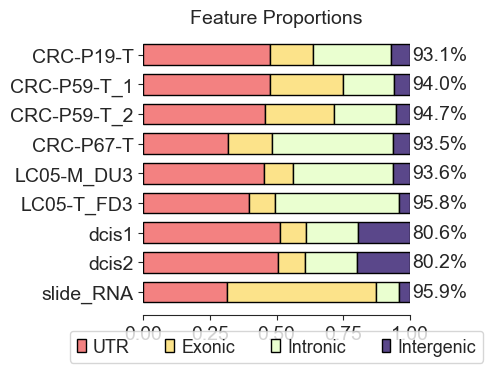

In [11]:
palette = ['#F38181','#FCE38A','#EAFFD0','#5A478A']
fig, ax = plt.subplots(figsize=(5, 4))
cumulative = np.cumsum(proportions.values, axis=1)
handles = []
for i, col in enumerate(proportions.columns):
    starts = cumulative[:, i-1] if i > 0 else np.zeros(proportions.shape[0])
    p = ax.barh(proportions.index, proportions[col], left=starts, height=0.7, color=palette[i], edgecolor='black')
    handles.append(p)
for i in range(proportions.shape[0]):
    ax.text(1.01, i, f"{(proportions.iloc[i, 0] + proportions.iloc[i, 1] + proportions.iloc[i, 2])*100:.1f}%", va='center')

ax.set_xlabel("")
ax.set_title("Feature Proportions")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(handles, proportions.columns, bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=len(proportions.columns))
plt.grid(False)
plt.gca().margins(x=0)
plt.tight_layout()
# plt.savefig('./MainFigure/Fig1d.pdf', bbox_inches='tight')
plt.show()

In [12]:
data = pd.DataFrame({
    'Sample': ['CRC-P59-T_1', 'CRC-P59-T_2', 'CRC-P67-T', 'LC05-M_P3', 'LC05-T_P3', 'DCIS1', 'DCIS2', 'Slide-RNA'],
    'Percentage': [93.2, 93.5, 94.4, 93.5, 93.6, 95.6, 81.7, 82.1]
})

In [13]:
data['platform'] = ['Stereo-seq']*5 + ['Visium']*2 + ['Slide-RNA']*1

/tmp/ipykernel_2452012/3558684811.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cat = sns.catplot(data = data,x = 'platform',y = 'Percentage',capsize = .1,errorbar = 'se',kind='bar',aspect = 1 ,palette=platform_to_color,edgecolor = 'black')


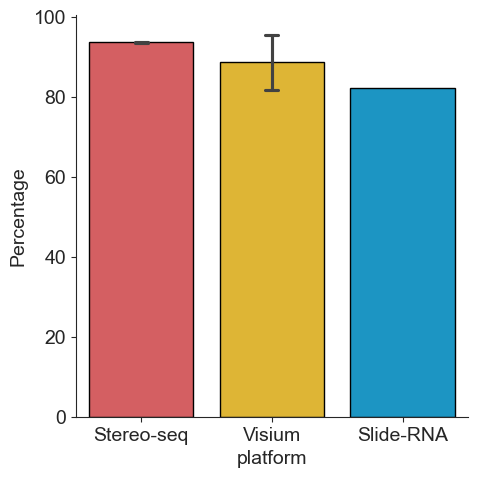

In [14]:
cat = sns.catplot(data = data,x = 'platform',y = 'Percentage',capsize = .1,errorbar = 'se',kind='bar',aspect = 1 ,palette=platform_to_color,edgecolor = 'black')

# fig1e

In [15]:
from upsetplot import from_contents
from upsetplot import UpSet

In [16]:
fromupset = from_contents(snv_set)

/home/liuyi/miniconda3/envs/SpatialBase/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


/home/liuyi/miniconda3/envs/SpatialBase/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/liuyi/miniconda3/envs/SpatialBase/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

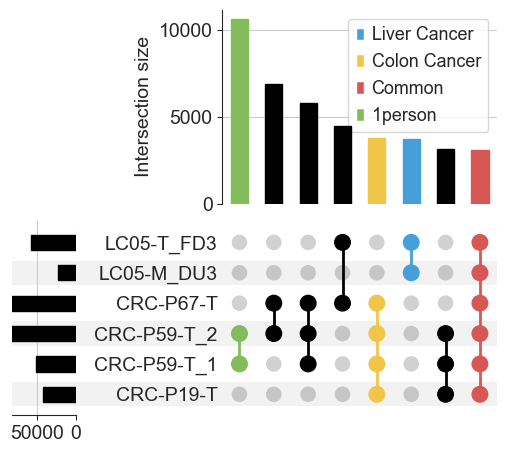

In [17]:
upset = UpSet(fromupset,sort_by = 'cardinality',sort_categories_by = 'input',min_degree = 2 ,subset_size="count",min_subset_size = 2500)
upset.style_subsets(present=["LC05-T_FD3", "LC05-M_DU3"],absent=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T'], facecolor="#479FDA", label="Liver Cancer")
upset.style_subsets(present=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T'],absent = ["LC05-T_FD3", "LC05-M_DU3"], facecolor="#F1C548", label="Colon Cancer")
upset.style_subsets(present=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T',"LC05-T_FD3", "LC05-M_DU3"], facecolor="#D75755", label="Common")
upset.style_subsets(present= ["CRC-P59-T_2","CRC-P59-T_1",],absent = ['CRC-P19-T',"LC05-T_FD3", "LC05-M_DU3","LC05-T_FD3", "LC05-M_DU3","CRC-P67-T"], facecolor="#83BC5B", label="1person")
upset.plot()
# plt.savefig('./MainFigure/commonsnv.pdf')

In [18]:
common_set = set(snv_set[next(iter(snv_set))])
for key in snv_set:
    common_set &= snv_set[key]

In [19]:
comdf = pd.DataFrame(common_set,columns = ['snv'])

In [20]:
comdf['chrom'] = comdf['snv'].map(lambda x : x.split('_')[0])
comdf['pos1'] = comdf['snv'].map(lambda x : int(x.split('_')[1].split(':')[0]))
comdf['pos2'] = comdf['snv'].map(lambda x : int(x.split('_')[1].split(':')[0]))

In [21]:
comdf[['chrom','pos1','pos2']].to_csv('comsnv.great.bed',index=None,header=None,sep = '\t')

In [136]:
snv = sc.read_h5ad(f'/storage/liuyi/00.SNP_project/new_article/SNV_process/CRC-P19-T.snv.h5ad')

In [143]:
comdf = snv[:,snv.var_names.isin(comdf['snv'])].var

In [150]:
comdf[comdf['Func_L0'] != 'Intergenic']['gene_name'].drop_duplicates().to_csv('comsnv.gene.txt',index=None,header=None)